# Ma 17

In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import constants
import sympy as sym
from sympy import sympify
import scipy.stats as stats

In [123]:
#Prints a value with its error in scientific notation up to its 2 decimal
def print_scientific(value,error):
    """
    value (float) : the value
    error (float) : the error
    
    Returns:
        (string) : formatted string with the value an error
    """
    base10_error=int(np.floor(np.log10(np.abs(error))))
    base10_value=int(np.floor(np.log10(np.abs(value))))
    digits=int(base10_value-base10_error+1)
    if digits<=0:
        digits=0
    base=10**base10_value
    string=f"({value/base:.{digits}f} ± {error/base:.{digits}f})·10^{base10_value}"
    return string

In [124]:
def compute_error(expression, variables, values, errors):
    """
    expression (string) : expression you used to compute the value
    variables  (list of strings) : list of variables that are in the expression in string form
    values     (list of float)   : list of values that go in the expression
    errors     (list of float)   : list of errors for each value
    
    Returns: (result, uncertainty) : tuple with the desired value and its uncertainty
    
    !! ATTENTION: Length variables = length values = length errors
    
    An example: 
    >   expression="x**2+y"
    >   var=["x","y"]; values=[2,1]; errors=[4,2]
    >   compute_error(expression, var, values, errors)
    """
    #Make variables and expression symbolic
    expression=sym.sympify(expression)
    variables=sym.symbols(variables)
    
    #To store coefficients
    coefficients=[]
    
    for index,variable in enumerate(
        variables):
        dexpression=sym.diff(expression, variable) #Differentiates expression
        coefficient=dexpression.subs(list(zip(variables, values))) #substitution
        coefficients.append(errors[index]*np.float64(coefficient)) #multiply coefficient times error
    
    uncertainty=np.sqrt(np.sum(np.array(coefficients)**2))
    result=np.float64(expression.subs(list(zip(variables, values))))

    return result,uncertainty
    

## Computing the mass of the monolayer

Text(0, 0.5, 'Frequency (Hz)')

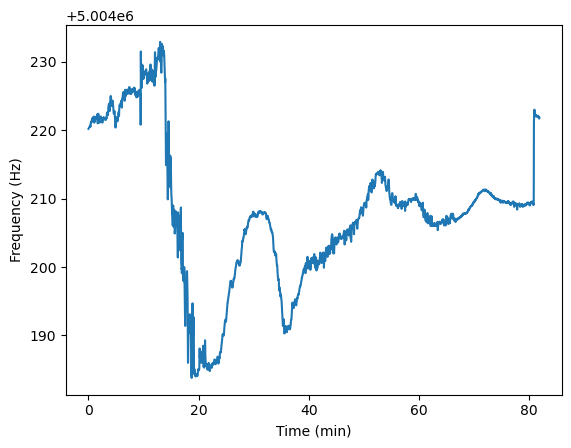

In [125]:
#Load dataframe
df=pd.read_csv(f"data/MUA-monolayer.csv", sep=";")
frequency=np.array(df["Frequency"])
time=np.array(df["Time (s)"])
plt.plot(time/60, frequency)
plt.xlabel("Time (min)")
plt.ylabel("Frequency (Hz)")

In [126]:
maxtime=time[frequency==np.max(frequency)][0]

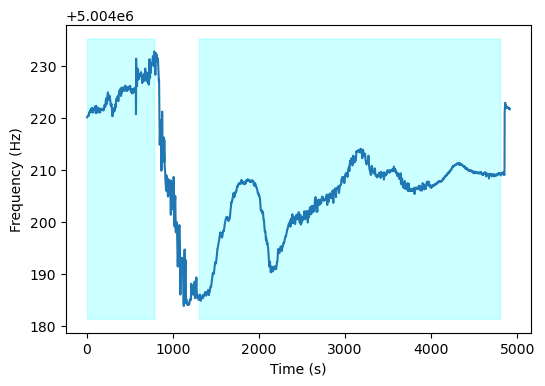

In [127]:
diff=np.max(frequency)-np.min(frequency)
fig, axis=plt.subplots(1,1,figsize=(6,4))
axis.plot(time, frequency)
axis.set_xlabel("Time (s)"); axis.set_ylabel("Frequency (Hz)")
axis.fill_between(time, np.min(frequency)-diff*0.05, np.max(frequency)+diff*0.05, where=time<=maxtime, alpha=0.2, color="cyan",
                 label="Air measurements")
axis.fill_between(time, np.min(frequency)-diff*0.05, np.max(frequency)+diff*0.05, where=[time>=1300 and time<=4800 for time in time],
                                                                                         alpha=0.2, color="cyan",
                 label="Air measurements")

### Baseline drift ethanol

Text(0, 0.5, 'Frequency (Hz)')

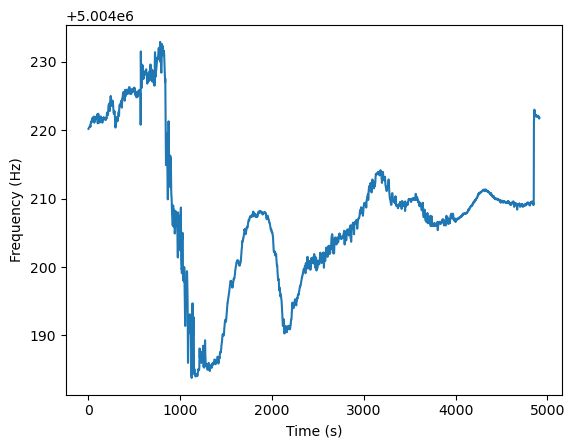

In [128]:
plt.plot(time, frequency)
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")

To compute the regression we will use the first seconds until the maximum.

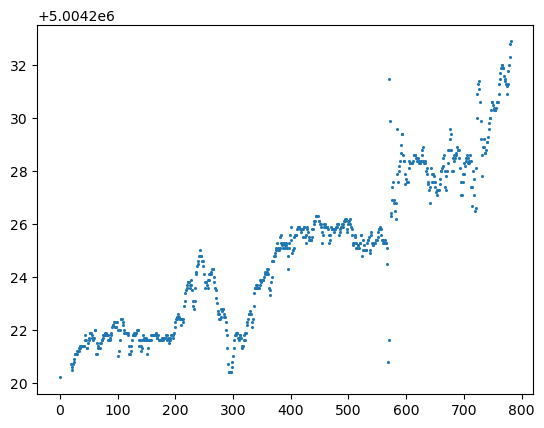

In [129]:
maxtime=time[frequency==np.max(frequency)][0]
freq_eth=frequency[time<=maxtime]
time_eth=time[time<=maxtime]
plt.scatter(time_eth, freq_eth, s=1.5)

Notice how there is an area of large noise between 500 and 600, I believe that here is where professor Arataka moved the liquid. We have to take it out.

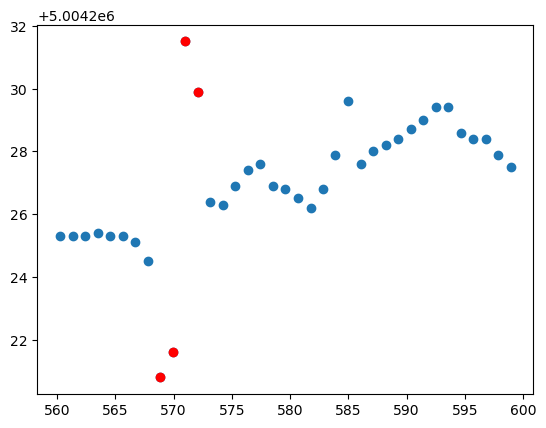

In [130]:
inspection=[time>560 and time<600 for time in time_eth]
to_delete=[time>568 and time<573 for time in time_eth]
plt.scatter(time_eth[inspection], freq_eth[inspection])
plt.scatter(time_eth[to_delete],freq_eth[to_delete], color="red")

We identify them as the four data points between 569 and 572

In [131]:
selection=np.array([time<568 or time>573 for time in time_eth])

In [132]:
linregression= stats.linregress(time_eth[selection], freq_eth[selection])
linregression_eth=linregression

In [138]:
print(f"We obtain a regression with slope "+print_scientific(linregression.slope,linregression.stderr)+" s^-2")
print(f"and an intercept of "+print_scientific(linregression.intercept,linregression.intercept_stderr)+" Hz")
print(f"With a p-value of {linregression.pvalue:.2E}<<0.05, for the null hypothesis: the slope is 0")
print(f"Finally the r^2 score is {linregression.rvalue:.2f}")



f_l = np.mean(freq_eth[selection])
Df_l = np.std(freq_eth[selection])

print(f"\n\nThe mean value for the frequency is {print_scientific(f_l, Df_l)} ")

We obtain a regression with slope (1.232 ± 0.018)·10^-2 s^-2
and an intercept of (5.004220012 ± 0.000000081)·10^6 Hz
With a p-value of 1.32E-318<<0.05, for the null hypothesis: the slope is 0
Finally the r^2 score is 0.93


The mean value for the frequency is (5.0042249 ± 0.0000029)·10^6 


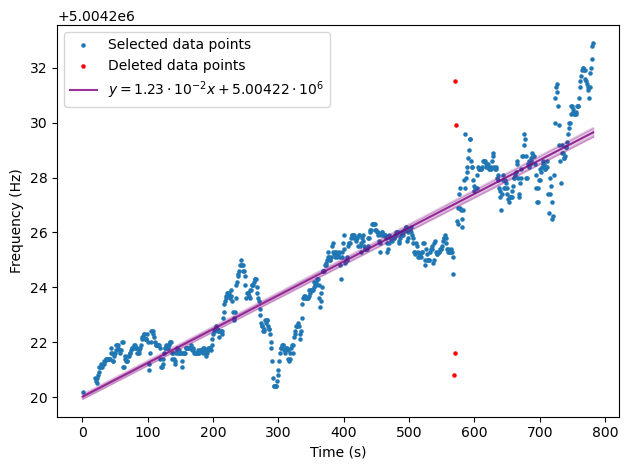

In [134]:
#Draw the graph with uncertainty in the slope
X=time_eth; Y=time_eth*linregression.slope+linregression.intercept;
uncertainty_regression=np.sqrt((X*linregression.stderr)**2+linregression.intercept_stderr**2)
plt.scatter(time_eth[selection], freq_eth[selection],s=5, label="Selected data points")
plt.scatter(time_eth[~selection], freq_eth[~selection],
            s=5,label="Deleted data points", color="red")
plt.plot(X,Y, color="purple", alpha=0.8, label=f"$y={linregression.slope/1e-2:.3}\cdot10^"+"{-2}"+f"x+{linregression.intercept/1e6:.8}\cdot 10^6$")
plt.plot(X,uncertainty_regression+Y, color="purple", alpha=0.2)
plt.plot(X,Y-uncertainty_regression, color="purple", alpha=0.2)
plt.fill_between(X, Y+uncertainty_regression, Y-uncertainty_regression,
                color="purple", alpha=0.2)
plt.legend()
plt.xlabel("Time (s)"); plt.ylabel("Frequency (Hz)")
plt.tight_layout()

Still deleting this points does not do much and the slope obtained for this baseline is different from the one we obtained before. However it is in the same order of magnitude.

Anyhow, we will use this baseline to compute the frequency change.

## Mass computation

Here we consider mass per unit of surface

In [147]:
deltaf_L

-714.1612821957096

In [148]:
rho_q=2.648*(constants.gram)*(constants.centi)**(-3)
stdrho_q=0.001*(constants.gram)*(constants.centi)**(-3)
deltaf_L, stddeltaf_L=np.load("results/task1/Deltaf_experimental.npy")
d_q, stdd_q=np.load("results/task1/d_q.npy")
f_0, stdf_0=np.load("results/task1/eigenfreq_air.npy")
A=np.pi*(constants.inch/2)**2
deltaf_L=-deltaf_L

Text(0, 0.5, 'Frequency (Hz)')

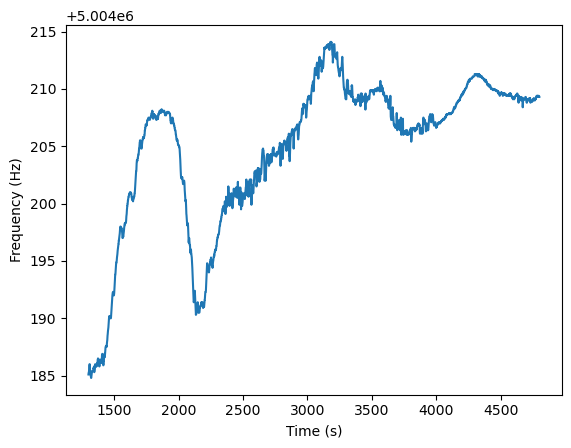

In [149]:
#We slice the array by eyeballing
selection_MUA=[time>=1300 and time<=4800 for time in time]
time_MUA=time[selection_MUA]
freq_MUA=frequency[selection_MUA]
plt.plot(time_MUA, freq_MUA)
plt.xlabel("Time (s)"); plt.ylabel("Frequency (Hz)")

In [152]:
deltaf_MUA=freq_MUA-(linregression_eth.slope*time_MUA+linregression.intercept)
mass=-(rho_q*d_q*A)/(f_0)*(deltaf_MUA)

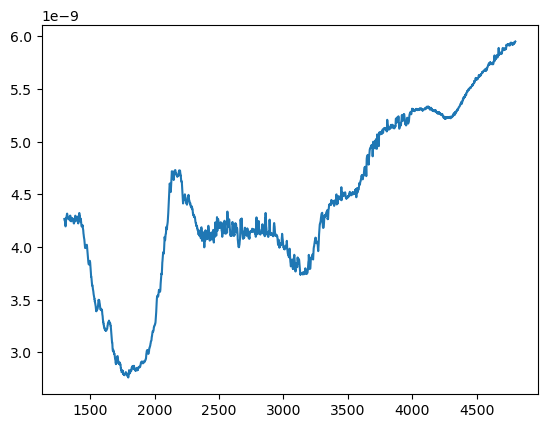

In [153]:
plt.plot(time_MUA, mass)

Text(0, 0.5, 'Mass (kg)')

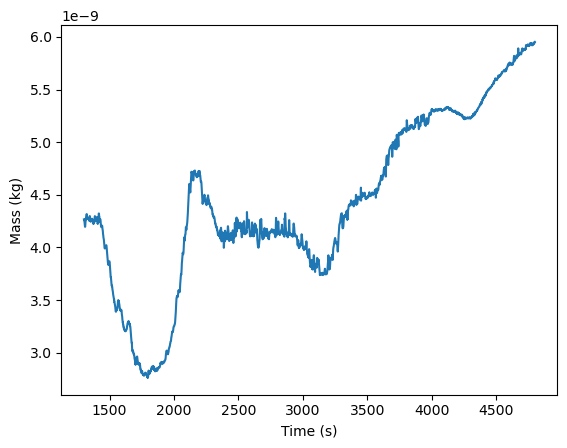

In [154]:
plt.plot(time_MUA, mass)
plt.xlabel("Time (s)"); plt.ylabel("Mass (kg)")

The order seems to be correct. Now let us look into the errors. Note that as acid binds the monolayer assembles.

### Now we compute the errors

In [155]:
stddeltaf_MUA=np.sqrt((time_MUA*linregression_eth.stderr)**2+linregression_eth.intercept_stderr**2)

In [156]:
expression="-(rho_q*d_q*A)/(f_0)*(deltaf_MUA)"
variables=["rho_q","d_q","A","f_0","deltaf_L","deltaf_MUA"]
mass_MUA=[];stdmass_MUA=[]
for index,deltaf in enumerate(deltaf_MUA):
    mass, stdmass=compute_error(expression,variables,[rho_q,d_q,A,f_0,deltaf_L,deltaf],
                  [stdrho_q,stdd_q,A*0.1,stdf_0,stddeltaf_L,stddeltaf_MUA[index]])
    mass_MUA.append(mass);stdmass_MUA.append(stdmass)
mass_MUA=np.array(mass_MUA); stdmass_MUA=np.array(stdmass_MUA)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


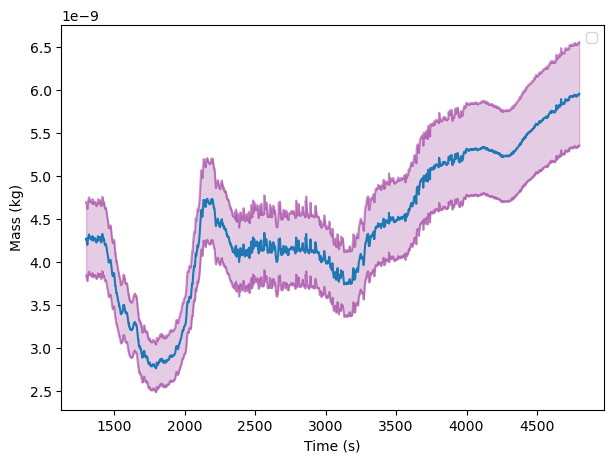

In [157]:
fig, axis=plt.subplots(1,1,figsize=(7,5))
axis.plot(time_MUA,mass_MUA)
axis.plot(time_MUA,mass_MUA+stdmass_MUA, color="purple", alpha=0.4)
axis.plot(time_MUA,mass_MUA-stdmass_MUA, color="purple", alpha=0.4)
axis.fill_between(time_MUA, mass_MUA+stdmass_MUA, mass_MUA-stdmass_MUA,
                color="purple", alpha=0.2)
axis.set_xlabel("Time (s)"); axis.set_ylabel("Mass (kg)")
axis.legend()

The drift is accounted for, so this increase in detected mass stems from the continuous adsorption of acid in the water. The first well could be a disturbance or a first round of reversible adsorption.

In [158]:
print("The mean detected mass is "+print_scientific(np.mean(mass_MUA), np.sqrt(np.std(mass_MUA)**2+np.mean(stdmass_MUA)**2))+" kg")

The mean detected mass is (4.43 ± 0.93)·10^-9 kg


### Detected molecules

In [159]:
atomicweight_MUA=218.356
weight_MUA=atomicweight_MUA*constants.physical_constants["atomic mass constant"][0]
molecules_MUA=mass_MUA/weight_MUA
mols_MUA=molecules_MUA/(constants.physical_constants["Avogadro constant"][0])
surface_MUA=molecules_MUA/A

In [160]:
avogadro=constants.physical_constants["Avogadro constant"][0]
expression=f"mass_MUA/(weight_MUA*A)"
variables=["mass_MUA","weight_MUA", "A"]
surface_MUA=[];stdsurface_MUA=[]
for index,mass in enumerate(mass_MUA):
    surface, stdsurface=compute_error(expression,variables,[mass, weight_MUA, A],
                  [stdmass_MUA[index], weight_MUA*0.001, A*0.1])
    surface_MUA.append(surface);stdsurface_MUA.append(stdsurface)
surface_MUA=np.array(surface_MUA); stdsurface_MUA=np.array(stdsurface_MUA)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


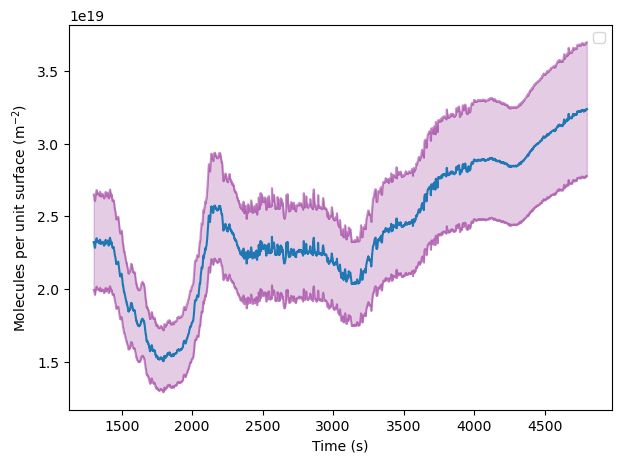

In [161]:
fig, axis=plt.subplots(1,1,figsize=(7,5))
axis.plot(time_MUA,surface_MUA)
axis.plot(time_MUA,surface_MUA+stdsurface_MUA, color="purple", alpha=0.4)
axis.plot(time_MUA,surface_MUA-stdsurface_MUA, color="purple", alpha=0.4)
axis.fill_between(time_MUA, surface_MUA+stdsurface_MUA, surface_MUA-stdsurface_MUA,
                color="purple", alpha=0.2)
axis.set_xlabel("Time (s)"); axis.set_ylabel("Molecules per unit surface (m$^{-2}$)")
axis.legend()

## Plot combined results

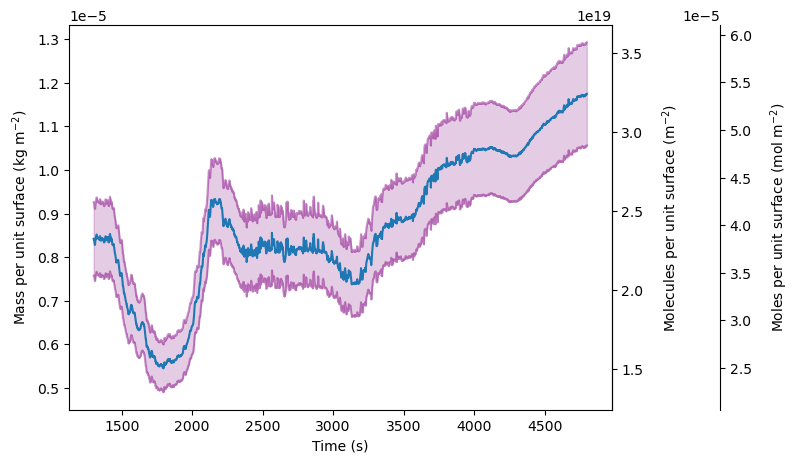

In [162]:
# Convert mass to molecules per unit surface
def mass_to_mol_per_units(m):
    return m / (weight_MUA)

# Convert molecules per unit surface to mass
def mol_per_units_to_mass(mol):
    return mol * (weight_MUA)

def mole_per_units_to_mass(mole):
    return mole * (weight_MUA*avogadro)

def mass_to_mole_per_units(m):
    return m / (weight_MUA*avogadro)

def rescale_mass(m):
    return m / A    

mass_pa_MUA = rescale_mass(mass_MUA)
stdmass_pa_MUA = rescale_mass(stdmass_MUA)

fig, ax = plt.subplots(1,1,figsize=(7,5))


ax.plot(time_MUA,mass_pa_MUA)
ax.plot(time_MUA,mass_pa_MUA+stdmass_pa_MUA, color="purple", alpha=0.4)
ax.plot(time_MUA,mass_pa_MUA-stdmass_pa_MUA, color="purple", alpha=0.4)
ax.fill_between(time_MUA, mass_pa_MUA+stdmass_pa_MUA, mass_pa_MUA-stdmass_pa_MUA,
                color="purple", alpha=0.2)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Mass per unit surface (kg m$^{-2}$)")

ax2 = ax.secondary_yaxis('right', functions=(mass_to_mol_per_units, mol_per_units_to_mass))
ax2.set_ylabel('Molecules per unit surface (m$^{-2}$)', labelpad=12)

ax3 = ax.secondary_yaxis(1.2, functions=(mass_to_mole_per_units, mole_per_units_to_mass))
ax3.set_ylabel('Moles per unit surface (mol m$^{-2}$)', labelpad=12)




plt.show()

## Not taking drift into account

In [163]:
deltaf_MUAnodrift=freq_MUA-(linregression.intercept)
mass_nodrift=-(rho_q*d_q*A)/(f_0)*(deltaf_MUAnodrift)

Text(0, 0.5, 'Mass (kg)')

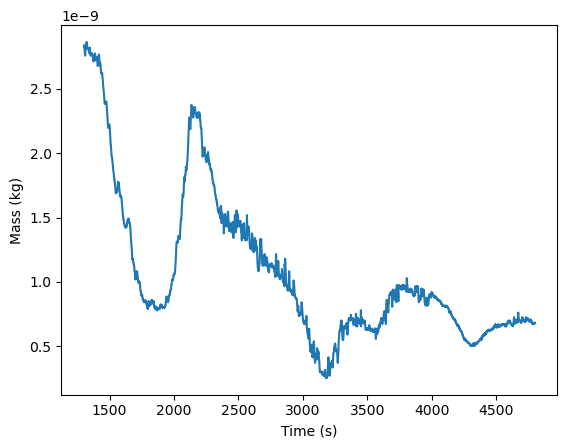

In [164]:
plt.plot(time_MUA, mass_nodrift)
plt.xlabel("Time (s)"); plt.ylabel("Mass (kg)")

In [165]:
stddeltaf_MUAnodrift=np.sqrt(linregression_eth.intercept_stderr**2+1)

In [166]:
expression="-(rho_q*d_q*A)/(f_0)*(deltaf_MUA)"
variables=["rho_q","d_q","A","f_0","deltaf_MUA"]
mass_MUAnodrift=[];stdmass_MUAnodrift=[]
for deltaf in deltaf_MUAnodrift:
    mass, stdmass=compute_error(expression,variables,[rho_q,d_q,A,f_0,deltaf],
                  [stdrho_q,stdd_q,A*0.1,stdf_0,stddeltaf_MUAnodrift])
    mass_MUAnodrift.append(mass);stdmass_MUAnodrift.append(stdmass)
mass_MUAnodrift=np.array(mass_MUAnodrift); stdmass_MUAnodrift=np.array(stdmass_MUAnodrift)

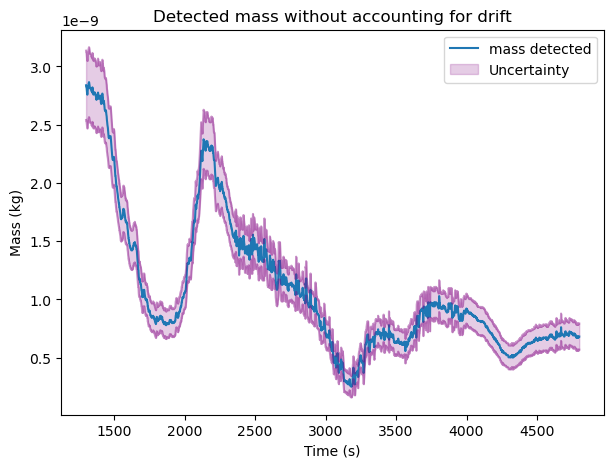

In [167]:
fig, axis=plt.subplots(1,1,figsize=(7,5))
axis.plot(time_MUA,mass_MUAnodrift, label="mass detected")
axis.plot(time_MUA,mass_MUAnodrift+stdmass_MUAnodrift, color="purple", alpha=0.4)
axis.plot(time_MUA,mass_MUAnodrift-stdmass_MUAnodrift, color="purple", alpha=0.4)
axis.fill_between(time_MUA, mass_MUAnodrift+stdmass_MUAnodrift, mass_MUAnodrift-stdmass_MUAnodrift,
                color="purple", alpha=0.2, label="Uncertainty")
axis.set_xlabel("Time (s)"); axis.set_ylabel("Mass (kg)")
axis.set_title("Detected mass without accounting for drift")
axis.legend()

This is a bit worrying as this graph could be interpreted as the system loosing mass from acid deadsorption which is also a reasonable hypothesis, however I still think that the picture that the drift hypothesis poses is sensible as it would make sense that acid would continously bind to the surface.

In [159]:
atomicweight_MUA=218.356
weight_MUAnodrift=atomicweight_MUA*constants.kilo*constants.physical_constants["atomic mass constant"][0]
molecules_MUAnodrift=mass_MUAnodrift/weight_MUAnodrift
mols_MUAnodrift=molecules_MUA/(constants.physical_constants["Avogadro constant"][0])
surface_MUAnodrift=molecules_MUAnodrift/A

In [160]:
avogadro=constants.physical_constants["Avogadro constant"][0]
expression=f"mass_MUAnodrift/(weight_MUA*A)"
variables=["mass_MUAnodrift","weight_MUA", "A"]
surface_MUAnodrift=[];stdsurface_MUAnodrift=[]
for index,mass in enumerate(mass_MUAnodrift):
    surface, stdsurface=compute_error(expression,variables,[mass, weight_MUA, A],
                  [stdmass_MUA[index], weight_MUA*0.001, A*0.1])
    surface_MUAnodrift.append(surface);stdsurface_MUAnodrift.append(stdsurface)
surface_MUAnodrift=np.array(surface_MUAnodrift); stdsurface_MUAnodrift=np.array(stdsurface_MUAnodrift)


No handles with labels found to put in legend.


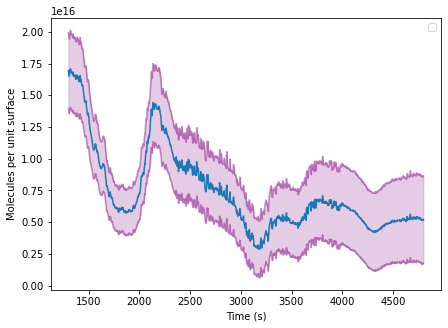

In [161]:
fig, axis=plt.subplots(1,1,figsize=(7,5))
axis.plot(time_MUA,surface_MUAnodrift)
axis.plot(time_MUA,surface_MUAnodrift+stdsurface_MUAnodrift, color="purple", alpha=0.4)
axis.plot(time_MUA,surface_MUAnodrift-stdsurface_MUAnodrift, color="purple", alpha=0.4)
axis.fill_between(time_MUA, surface_MUAnodrift+stdsurface_MUAnodrift, surface_MUAnodrift-stdsurface_MUAnodrift,
                color="purple", alpha=0.2)
axis.set_xlabel("Time (s)"); axis.set_ylabel("Molecules per unit surface")
axis.legend()

## Save

In [97]:
linregression_ethnpy=np.array([linregression_eth.slope, linregression_eth.intercept, linregression_eth.rvalue, linregression_eth.pvalue, linregression_eth.stderr, linregression_eth.intercept_stderr])

In [162]:
np.save("results/task2/mass_MUA.npy",(mass_MUA,stdmass_MUA))
np.save("results/task2/mass_MUAnodrift.npy",(mass_MUAnodrift, stdmass_MUAnodrift))
np.save("results/task2/linregression_eth.npy",linregression_ethnpy)

## Compute $f_{L+M}$ and get value for mass

Text(0, 0.5, 'Frequency (Hz)')

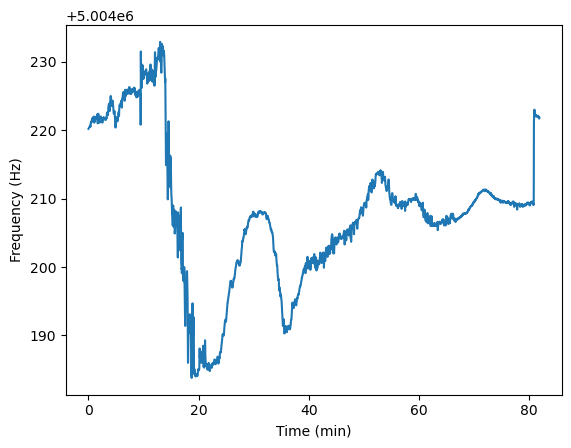

In [171]:
#We slice the array by eyeballing
df=pd.read_csv(f"data/MUA-monolayer.csv", sep=";")
frequency=np.array(df["Frequency"])
time=np.array(df["Time (s)"])
plt.plot(time/60, frequency)
plt.xlabel("Time (min)")
plt.ylabel("Frequency (Hz)")

Frequency (5.00420926 ± 0.00000022)·10^6 Hz


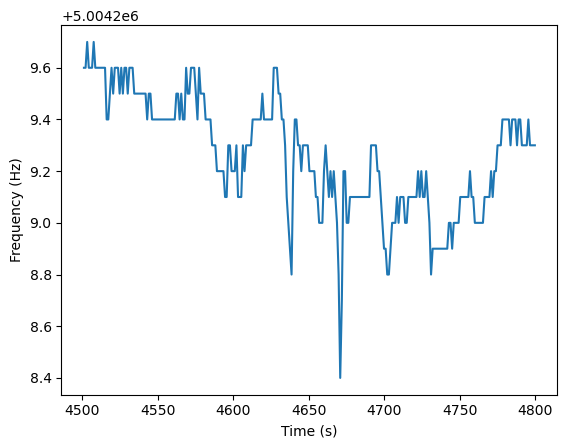

In [172]:
#We slice the array by eyeballing
selection_MUA=[time>=4500 and time<=4800 for time in time]
time_MUA=np.array(time[selection_MUA])
freq_MUA=np.array(frequency[selection_MUA])

f_lm, Df_lm = freq_MUA.mean(),np.std(freq_MUA)
print(f"Frequency {print_scientific(f_lm, Df_lm)} Hz")

plt.plot(time_MUA, freq_MUA)
plt.xlabel("Time (s)"); plt.ylabel("Frequency (Hz)")
plt.show()

check the linear hypotesis 

We obtain a regression with slope (-1.65 ± 0.12)·10^-3 s^-2
and an intercept of (5.00421695 ± 0.00000055)·10^6 Hz
With a p-value of 6.76E-34<<0.05, for the null hypothesis: the slope is 0
Finally the r^2 score is -0.64


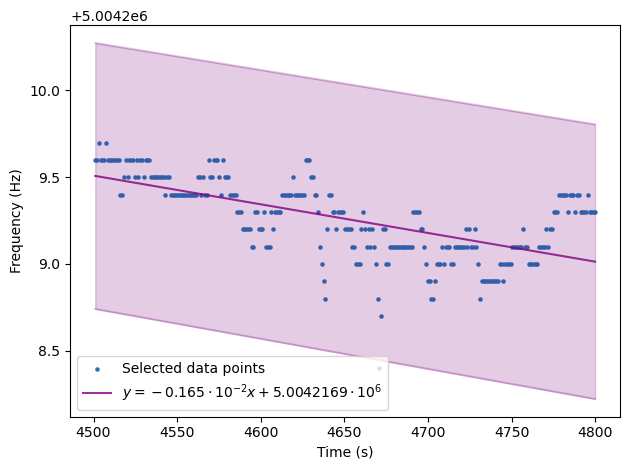

In [173]:
linregression= stats.linregress(time_MUA, freq_MUA)
linregression_MUA=linregression

print(f"We obtain a regression with slope "+print_scientific(linregression.slope,linregression.stderr)+" s^-2")
print(f"and an intercept of "+print_scientific(linregression.intercept,linregression.intercept_stderr)+" Hz")
print(f"With a p-value of {linregression.pvalue:.2E}<<0.05, for the null hypothesis: the slope is 0")
print(f"Finally the r^2 score is {linregression.rvalue:.2f}")

#Draw the graph with uncertainty in the slope
X=time_MUA; Y=time_MUA*linregression.slope+linregression.intercept;
uncertainty_regression=np.sqrt((X*linregression.stderr)**2+linregression.intercept_stderr**2)
plt.scatter(time_MUA, freq_MUA,s=5, label="Selected data points")

plt.plot(X,Y, color="purple", alpha=0.8, label=f"$y={linregression.slope/1e-2:.3}\cdot10^"+"{-2}"+f"x+{linregression.intercept/1e6:.8}\cdot 10^6$")
plt.plot(X,uncertainty_regression+Y, color="purple", alpha=0.2)
plt.plot(X,Y-uncertainty_regression, color="purple", alpha=0.2)
plt.fill_between(X, Y+uncertainty_regression, Y-uncertainty_regression,
                color="purple", alpha=0.2)
plt.legend()
plt.xlabel("Time (s)"); plt.ylabel("Frequency (Hz)")
plt.tight_layout()



## Compute the mass 

In [174]:
rho_q = 2.648*(constants.gram)*(constants.centi)**(-3)
stdrho_q = 0.001*(constants.gram)*(constants.centi)**(-3)
#deltaf_L, stddeltaf_L = np.load("results/task1/Deltaf_experimental.npy")
d_q, stdd_q = np.load("results/task1/d_q.npy")
f_0, stdf_0 = np.load("results/task1/eigenfreq_air.npy")
f_l, stdf_l = f_l, Df_l
#A=np.pi*(constants.inch/2)**2
f_lm, stdf_lm = f_lm, Df_lm
K_R=1664

In [177]:
rho_q = 2.648*(constants.gram)*(constants.centi)**(-3)
stdrho_q = 0.001*(constants.gram)*(constants.centi)**(-3)
deltaf_L, stddeltaf_L = np.load("results/task1/Deltaf_experimental.npy")
d_q, stdd_q = np.load("results/task1/d_q.npy")
f_0, stdf_0 = np.load("results/task1/eigenfreq_air.npy")
f_l, stdf_l = f_0-deltaf_L, stddeltaf_L-stdf_0
#A=np.pi*(constants.inch/2)**2
f_lm, stdf_lm = f_lm, Df_lm
K_R=1664

In [180]:
detected_mass = (rho_q*K_R/f_0)*np.abs((1-f_lm/f_l))
stddetected_mass = rho_q*K_R*np.sqrt(((1-f_lm/f_l)*stdf_0/(f_0**2))**2 + (stdf_lm/(f_0*f_l))**2 + (f_lm*stdf_l/(f_0*f_l**2))**2)

print(f"Result for the mass {print_scientific(detected_mass, stddetected_mass)}")

Result for the mass (8.28 ± 0.88)·10^-7


In [179]:
f_l

5004204.555881984